<a href="https://colab.research.google.com/github/nandhinianandj/EmoPy/blob/master/PyMC_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I will try to implement and analyze LDA algorithm using PyMC package. The implementation is replication of the code provided at: http://stats.stackexchange.com/questions/104771/latent-dirichlet-allocation-in-pymc

The LDA model is described below:
![LDA Model](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Latent_Dirichlet_allocation.svg/250px-Latent_Dirichlet_allocation.svg.png)

In [3]:
!pip install pymc

     |████████████████████████████████| 389kB 7.1MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp27-cp27mu-linux_x86_64.whl size=1044688 sha256=165646318f9a53fbfa7d4c98f84feb76d1e8f784ead70bbb50c7ec8440855959
  Stored in directory: /root/.cache/pip/wheels/0b/a8/e7/8f3ba91a39294d538a92db052fd1fcba1fca74a58c8b022026
Successfully built pymc


In [15]:
import numpy as np
import pymc as pm
#K, V, D = 2, 4, 3 # number of topics, words, documents
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
%matplotlib inline
import nltk
nltk.download('stopwords')
nltk.download('all')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection u'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unz

True

In [5]:
K, V, D = 5, 10, 20 # number of topics, words, documents

#data = np.array([[1, 1, 1, 1], [1, 1, 1, 1], [0, 0, 0, 0]])

data_temp = np.random.randint(0,10,size=(D,V))

In [6]:
class LDA(object):
    
    def __init__(self, data, topics=K, vocab=V):
        """
        Takes the data variable and outputs a model
        """
        self.data = data
        self.topics = topics
        self.vocab = vocab+1
        self.docs = len(self.data)
        self.alpha = np.ones(self.topics)
        self.beta = np.ones(self.vocab)

        self.theta = pm.Container([pm.CompletedDirichlet("theta_%s" % i,\
                                                         pm.Dirichlet("ptheta_%s" % i, theta=self.alpha))
                                   for i in range(self.docs)])
        self.phi = pm.Container([pm.CompletedDirichlet("phi_%s" % i,\
                                                       pm.Dirichlet("pphi_%s" % i, theta=self.beta))
                                 for i in range(self.topics)])
        self.Wd = [len(doc) for doc in self.data]

        self.Z = pm.Container([pm.Categorical("z_%s" % d, 
                                              p=self.theta[d],
                                              size=self.Wd[d],
                                              value=np.random.randint(self.topics,size=self.Wd[d]))
                               for d in range(self.docs)])
        self.W = pm.Container([pm.Categorical("w_%s,%s" % (d,i),
                                              p=pm.Lambda("phi_z_%s_%s" % (d,i), 
                                                          lambda z=self.Z[d][i], phi=self.phi: phi[z]),
                                              value=self.data[d][i],
                                              observed=True)
                               for d in range(self.docs) for i in range(self.Wd[d])])

        self.model = pm.Model([self.theta, self.phi, self.Z, self.W])
        self.mcmc = pm.MCMC(self.model)
    
    def fit(self, iterations=1000, burn_in=10):
        # Fit the model by sampling from the data iterations times with burn in of burn_in.
        self.mcmc.sample(iterations, burn=burn_in)
        
    def show_topics(self):
        # Show distribution of topics over words
        return self.phi.value
    
    def show_words(self):
        # Show distribution of words in documents over topics
        return self.W.value
    
    def KLDiv(self, p,q):
        return np.sum(p*np.log10(p/q))
    
    def cosine_sim(self, x,y):
        return np.dot(x,y)/np.sqrt(np.dot(x,x)*np.dot(y,y))
    
    def sorted_docs_sim(self):
        kldivs_docs = [(i, j, self.KLDiv(self.theta[i].value,self.theta[j].value),
                        self.cosine_sim(self.data[i], self.data[j]))
                       for i in range(len(self.theta)) for j in range(len(self.theta))
                       if i != j]
        return sorted(kldivs_docs, key=lambda x: x[3], reverse=True)
    
    def show_topic_words(self, idwords, n=10):
        for i, t in enumerate(self.phi.value):
            print "Topic %i : " % i, ", ".join(idwords[w_] for w_ in np.argsort(t[0])[-10:] if w_ < (self.vocab-1-1))
    
    def plot_data(self):
        plt.clf()
        plt.matshow(data, fignum=1000, cmap=plt.cm.Reds)
        plt.gca().set_aspect('auto')
        plt.xlabel("Words")
        plt.ylabel("Documents")
    
    def plot_words_per_topic(self, ax=None):
        if ax is None:
            plt.clf()
            fig, ax = plt.subplots(1,1)
        words = self.Z.value
        topic_dist = dict()
        for k_i in words:
            for k in k_i:
                if k not in topic_dist:
                    topic_dist[k] = 0
                topic_dist[k] += 1
        ax.bar(topic_dist.keys(), topic_dist.values())
        ax.set_xlabel("Topics")
        ax.set_ylabel("Counts")
        ax.set_title("Document words per topics")
        plt.show()
        
    def plot_word_dist(self, ax=None):
        topics = self.phi.value
        if ax is None:
            plt.clf()
            fig, ax = plt.subplots((len(topics)+1)/2, 2, figsize=(10,10))
        for i, t in enumerate(topics):
            ax[i/2][i%2].bar(range(len(t[0])), t[0])
            ax[i/2][i%2].set_title("Topic %s" % i)
        plt.suptitle("Vocab word proportions per topic")
        fig.subplots_adjust(hspace=0.5, wspace=0.5)

/usr/local/lib/python2.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 1000 of 1000 complete in 2.9 sec

<Figure size 432x288 with 0 Axes>

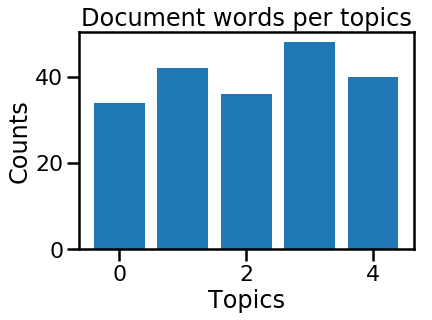

In [7]:
lda = LDA(data_temp)
lda.fit()
lda.plot_words_per_topic()

<Figure size 432x288 with 0 Axes>

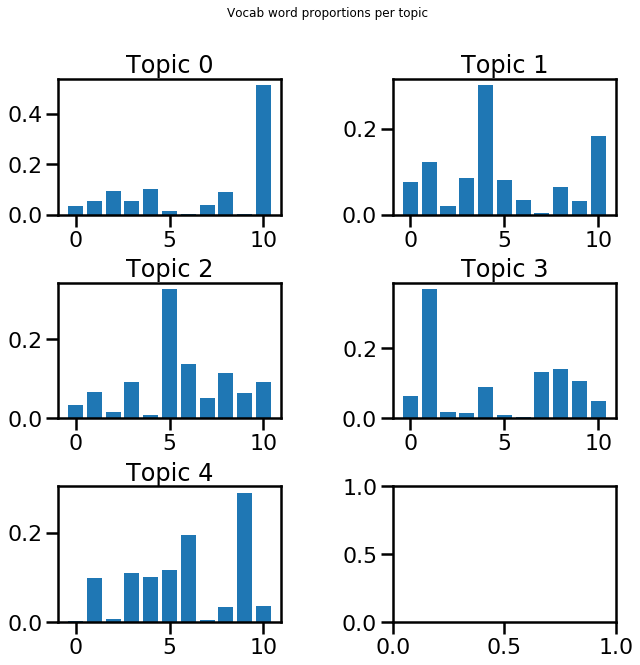

In [8]:
lda.plot_word_dist()

In [9]:
kld_sorted = lda.sorted_docs_sim()
kld_sorted[:10]

[(8, 15, 0.4488968443247371, 0.9387927351500112),
 (15, 8, 0.7476607916693249, 0.9387927351500112),
 (3, 15, 0.32711012141571283, 0.9340143743249688),
 (15, 3, 0.4976760251165271, 0.9340143743249688),
 (14, 16, 0.21443287144385909, 0.9333062381761031),
 (16, 14, 0.18142089772468184, 0.9333062381761031),
 (1, 3, 0.24505844795703471, 0.9307710367569052),
 (3, 1, 0.4328495761417804, 0.9307710367569052),
 (1, 11, 2.214668543729722, 0.9103107967494247),
 (11, 1, 0.9632598401678891, 0.9103107967494247)]

# REAL DATA
Now lets move to trying on some real world data. I will use the reuters corpus.

In [16]:
from nltk.corpus import inaugural
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

In [17]:
# Create a vocabulary from the corpus
vocab = dict()
for fileid in inaugural.fileids():
    for word in inaugural.words(fileid):
        word = word.lower()
        if word not in stops and word.isalpha():
            if word not in vocab:
                vocab[word] = 0
            vocab[word] += 1

In [18]:
"""
Sort the vocab keep only words which occur more than 50 times
Then Create word to id and id to word dictionaries
"""
vocab_sorted = filter(lambda x: x[1] > 50, sorted(vocab.items(), key=lambda x: x[1], reverse=True))
wordids = {v[0]: i for i, v in enumerate(vocab_sorted)}
idwords = {i: v[0] for i, v in enumerate(vocab_sorted)}
vocab_size = len(wordids)
print vocab_size

201


In [19]:
# Generate corpus document vectors
data = []
for fileid in inaugural.fileids():
    data.append([0]*vocab_size)
    for word in inaugural.words(fileid):
        word = word.lower()
        if word in wordids:
            data[-1][wordids[word]] += 1

len(data)

58

[8, 4, 1, 0, 3, 3, 1, 6, 2, 5]


Text(0,0.5,'Documents')

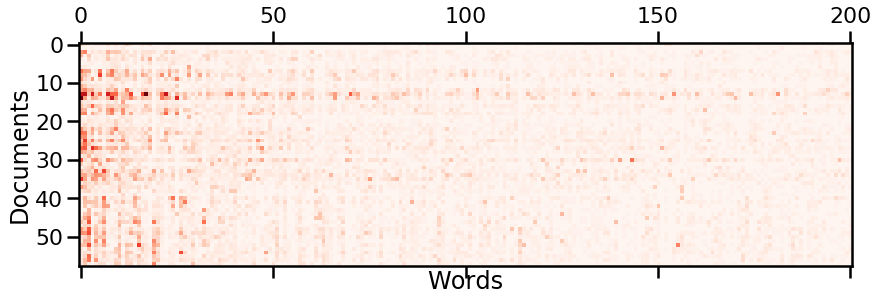

<Figure size 432x288 with 0 Axes>

In [20]:
# Plot the document word matrix
print data[0][:10]
data = np.array(data)
plt.clf()
plt.matshow(data, fignum=1000, cmap=plt.cm.Reds)
plt.gca().set_aspect('auto')
plt.xlabel("Words")
plt.ylabel("Documents")

In [21]:
inaugural_lda = LDA(data, topics=10, vocab=vocab_size)

 [-----------------100%-----------------] 1001 of 1000 complete in 53.5 sec

<Figure size 432x288 with 0 Axes>

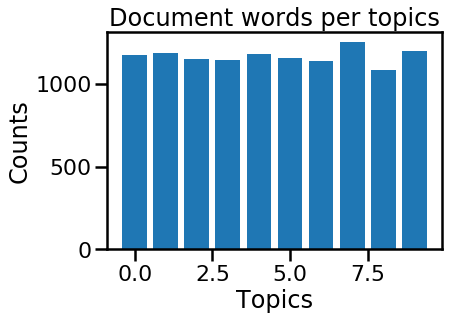

In [22]:
inaugural_lda.fit()
inaugural_lda.plot_words_per_topic()

<Figure size 432x288 with 0 Axes>

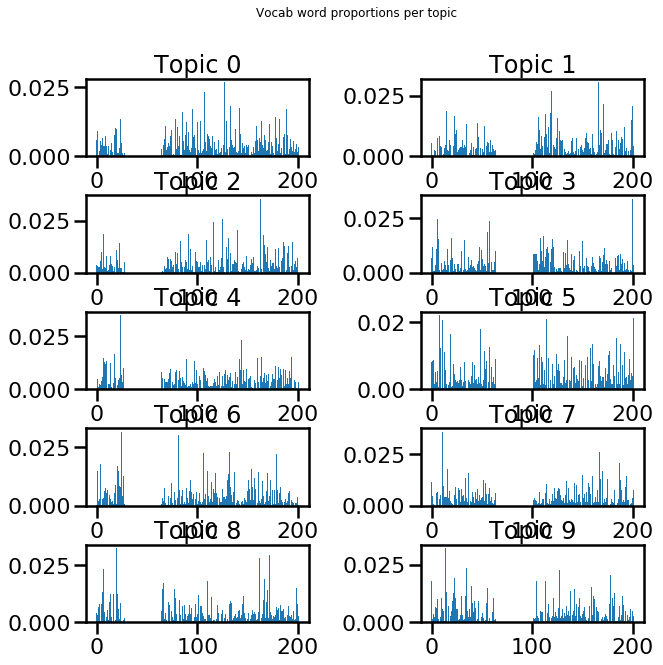

In [23]:
inaugural_lda.plot_word_dist()

<Figure size 432x288 with 0 Axes>

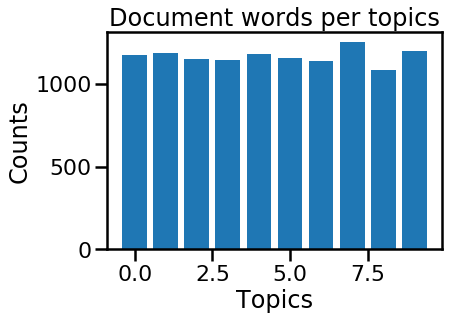

In [24]:
# Above diagram is wrong for Document words per topics

plt.clf()
fig, ax = plt.subplots(1,1)
words = inaugural_lda.Z.value
topic_dist = dict()
for k_i in words:
    for k in k_i:
        if k not in topic_dist:
            topic_dist[k] = 0
        topic_dist[k] += 1
ax.bar(topic_dist.keys(), topic_dist.values())
ax.set_xlabel("Topics")
ax.set_ylabel("Counts")
ax.set_title("Document words per topics")
plt.show()


In [25]:
for i, t in enumerate(inaugural_lda.phi.value):
    print "Topic %i : " % i, ", ".join(idwords[w_] for w_ in np.argsort(t[0])[-10:] if w_ < vocab_size -1)

Topic 0 :  live, confidence, meet, party, true, given, today, interest, god, find
Topic 1 :  better, united, office, purpose, home, new, beyond, even, stand
Topic 2 :  common, equal, order, stand, may, service, proper, could, change, respect
Topic 3 :  may, time, others, general, always, among, executive, many, world
Topic 4 :  purpose, god, principle, may, cause, experience, public, man, important, nations
Topic 5 :  past, full, still, america, best, together, shall, americans, states
Topic 6 :  need, people, character, would, must, strong, better, whose, whole, union
Topic 7 :  principle, experience, seek, years, protection, citizens, economy, yet, course, shall
Topic 8 :  life, powers, made, need, course, may, question, cannot, foreign, time
Topic 9 :  toward, life, come, government, office, united, live, find, good, peace
